In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install ipdb

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

https://jfking50.github.io/lunar/

https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html

# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


In [2]:
import gym
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

from IPython.display import clear_output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
env = gym.make('LunarLander-v2')

In [4]:
states_size = env.observation_space.shape[0]
actions_size = env.action_space.n


In [5]:
actions_size

4

In [6]:
states_size


8

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):
    def __init__(self,states_size, actions_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(states_size, 256) #Input layer
        # self.drop1 = nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(256, 512)
        # self.drop2 = nn.Dropout(p=0.6)
        self.fc3 = nn.Linear(512, 256)
        # self.drop3 = nn.Dropout(p=0.6)
        self.fc4 = nn.Linear(256, actions_size) #Output layer
    
    def forward(self, state):
        x = self.fc1(state)
        # x = self.drop1(x)
        x = F.relu(x)

        x = self.fc2(x)
        # x = self.drop2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        # x = self.drop3(x)
        x = F.relu(x)

        x = self.fc4(x)

        return x



In [9]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold: #greedy
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else: #random
        return torch.tensor([[random.randrange(actions_size)]], device=device, dtype=torch.long)


def optimize_model():
    if len(replay_memory) < BATCH_SIZE:
        return
    transitions = replay_memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# Why does rewards average go down the more you train
#https://datascience.stackexchange.com/questions/56053/why-could-my-ddqn-get-significantly-worse-after-beating-the-game-repeatedly
def plot_rewards():
    plt.figure(2)
    plt.clf()
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    plt.title('Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 50:
        means = rewards_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())

In [10]:
policy_net = DQN(states_size, actions_size).to(device)
target_net = DQN(states_size, actions_size).to(device)

# copy parameters from policy to target
target_net.load_state_dict(policy_net.state_dict())
# Set eval mode for target net
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())

replay_memory = ReplayMemory(10000)

Episode 299 Reward -144.91944788730433	Last 50 Average Score: -80.22Done


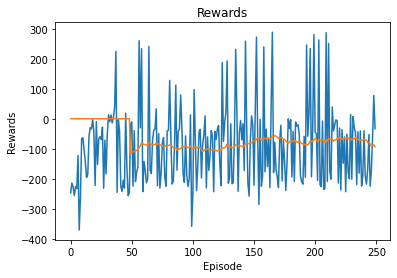

In [12]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

steps_done = 0


rewards = []
rewards_50 = deque(maxlen=50)

EPISODES = 300

for episode in range(EPISODES):
    state = env.reset()
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    current_reward = 0

    for t in count():
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
        
        # Update reward
        current_reward += reward
        
        # Store transition
        reward = torch.tensor([reward], device=device)
        replay_memory.push(state, action, next_state, reward)

        # Move to next state
        state = next_state

        optimize_model()

        if done:
            break
    
    if not episode%50:
        plot_rewards()
    
    rewards.append(current_reward)
    rewards_50.append(current_reward)
    avg = np.mean(rewards_50)

    print('\rEpisode {} Reward {}\tLast 50 Average Score: {:.2f}'.format(episode,
                                                                 current_reward,
                                                                 avg), end="")

print("Done")








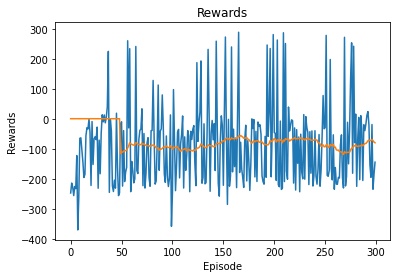

In [13]:
plot_rewards()

In [33]:
def play_game(render):
    done = False
    state = env.reset()
    reward_total = 0

    while not done:
        state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = policy_net(state_t).max(1)[1].view(1, 1)
        
        state, reward, done, _ = env.step(action.item())
        reward_total += reward
        
        if render: env.render()
        
    
    if render:
        env.close()
        show_video()
    
    print(f'reward = {reward_total}')
    

In [43]:
# How to get gym AI visuals in colab
# https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj

from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [42]:
env = wrap_env(gym.make('LunarLander-v2'))
play_game(render=True)

reward = 245.96962929398336
